In [1]:
import os
import pickle
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    Conv2D, Activation, BatchNormalization, Dropout, UpSampling2D, Input, Concatenate,
    Multiply, GlobalAveragePooling2D, Reshape, Dense, Add, AveragePooling2D, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

In [2]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
# Constants
IMAGE_SIZE = 256
EPOCHS = 30
BATCH = 8
LR = 1e-4
PATH = "C:\\Users\\saika\\OneDrive\\Desktop\\brats"


In [3]:
# Load and split data
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images", "*")))
    masks = sorted(glob(os.path.join(path, "masks", "*")))
    assert len(images) == len(masks), "Number of images and masks do not match"
    for img, mask in zip(images, masks):
        assert os.path.basename(img) == os.path.basename(mask), "Mismatched image and mask pairs"
    train_x, valid_x = train_test_split(images, test_size=split, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split, random_state=42)
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


In [4]:
# Read and preprocess images
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x / 255.0  
    return x.astype(np.float32)

# Read and preprocess masks
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)  
    x = x / 255.0  
    x = (x > 0.5).astype(np.float32)  
    return x


In [5]:
# Data augmentation
def augment_data(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.rot90(image, k=1)
        mask = tf.image.rot90(mask, k=1)
    return image, mask

# Parse image and mask pairs
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y


In [6]:
# Create TensorFlow dataset with augmentation
def tf_dataset(x, y, batch=BATCH, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    if augment:
        dataset = dataset.map(augment_data)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset


In [14]:
# UMobileNetV2 Model
def munet_model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model = MobileNetV2(input_tensor=inputs, include_top=False, weights="imagenet")
    
    # Encoder layers
    skip_connections = [
        base_model.get_layer('block_1_expand_relu').output,  # 112x112
        base_model.get_layer('block_3_expand_relu').output,  # 56x56
        base_model.get_layer('block_6_expand_relu').output,  # 28x28
        base_model.get_layer('block_13_expand_relu').output # 14x14
    ]
    encoder_output = base_model.get_layer('block_16_project').output  # 7x7
    
    # Decoder
    x = UpSampling2D(size=(2, 2))(encoder_output)  # 14x14
    x = Concatenate()([x, skip_connections[3]])
    x = Conv2D(192, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D(size=(2, 2))(x)  # 28x28
    x = Concatenate()([x, skip_connections[2]])
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D(size=(2, 2))(x)  # 56x56
    x = Concatenate()([x, skip_connections[1]])
    x = Conv2D(48, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D(size=(2, 2))(x)  # 112x112
    x = Concatenate()([x, skip_connections[0]])
    x = Conv2D(32, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D(size=(2, 2))(x)  # 224x224
    x = Conv2D(16, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model


In [15]:
model = munet_model()
model.summary()

C:\Users\saika\AppData\Local\Temp\ipykernel_19876\3143171166.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=inputs, include_top=False, weights="imagenet")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 128, 128, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 128, 128, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 128, 128, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 128, 128, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 128, 128, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 128, 128, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 128, 128, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 128, 128, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 128, 128, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 128, 128, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 128, 128, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 129, 129, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 64, 64, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 3,749,169 (14.30 MB)

 Trainable params: 3,717,553 (14.18 MB)

 Non-trainable params: 31,616 (123.50 KB)

In [16]:
# Dice coefficient
def dice_coef(y_true, y_pred, smooth=1e-15):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2.0 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Tversky loss
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-15):
    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos))
    false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos)
    return 1 - (true_pos + smooth) / (true_pos + alpha * false_pos + beta * false_neg + smooth)
# Accuracy metric
def accuracy(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    y_pred = tf.round(y_pred)  # Convert probabilities to binary predictions
    correct_predictions = tf.equal(y_true, y_pred)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))


In [17]:
# Load data
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)
print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))
# Create datasets
train_dataset = tf_dataset(train_x, train_y, batch=BATCH, augment=True)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)


Training data:  2481
Validation data:  307
Testing data:  276


In [18]:
from tensorflow.keras.models import load_model

model_path = "munet_segmentation_model.h5"

if os.path.exists(model_path):
    model = load_model(
        model_path,
        custom_objects={
            'tversky_loss': tversky_loss,
            'dice_coef': dice_coef,
            'accuracy': accuracy
        }
    )
    print("Model loaded from file. Skipping training.")
    skip_training = True
else:
    skip_training = False


In [19]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

In [20]:
# Paths for model and history
model_path = 'munet_segmentation_model.h5'
history_path = 'munet_training_history.pkl'

# Check if model exists
if os.path.exists(model_path):
    model = load_model(
        model_path,
        custom_objects={'tversky_loss': tversky_loss, 'dice_coef': dice_coef, 'accuracy': accuracy}
    )
    print("Model loaded from file. Skipping training.")

    # Load training history
    if os.path.exists(history_path):
        with open(history_path, 'rb') as f:
            history_data = pickle.load(f)
        print("Training history loaded.")
    else:
        history_data = None

    skip_training = True
else:
    skip_training = False
    history_data = None


C:\Users\saika\AppData\Local\Temp\ipykernel_19876\3143171166.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=inputs, include_top=False, weights="imagenet")


Epoch 1/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 332s 957ms/step - accuracy: 0.6926 - dice_coef: 0.0724 - loss: 0.9470 - val_accuracy: 0.9773 - val_dice_coef: 0.0913 - val_loss: 0.9323 - learning_rate: 1.0000e-04
Epoch 2/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 285s 923ms/step - accuracy: 0.9569 - dice_coef: 0.1150 - loss: 0.9138 - val_accuracy: 0.9848 - val_dice_coef: 0.1109 - val_loss: 0.9165 - learning_rate: 1.0000e-04
Epoch 3/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 284s 916ms/step - accuracy: 0.9720 - dice_coef: 0.1450 - loss: 0.8903 - val_accuracy: 0.9801 - val_dice_coef: 0.1515 - val_loss: 0.8845 - learning_rate: 1.0000e-04
Epoch 4/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 287s 927ms/step - accuracy: 0.9803 - dice_coef: 0.1862 - loss: 0.8573 - val_accuracy: 0.9733 - val_dice_coef: 0.1900 - val_loss: 0.8542 - learning_rate: 1.0000e-04
Epoch 5/30
310/310 ━━━━━━━━━━━━━━━━━━━━ 277s 893ms/step - accuracy: 0.9843 - dice_coef: 0.2400 - loss: 0.8126 - val_accuracy: 0.9854 - val_dice_coef: 0.2435 - val_loss: 0.8079 - learni

Model trained and saved.


In [21]:
# Evaluate the model on the test set
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)
test_steps = len(test_x) // BATCH
if len(test_x) % BATCH != 0:
    test_steps += 1
results = model.evaluate(test_dataset, steps=test_steps)
print("Test Loss:", results[0])
print("Test Dice Coefficient:", results[1])
print("Test Accuracy:", results[2])

35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step - accuracy: 0.9948 - dice_coef: 0.8313 - loss: 0.1406
Test Loss: 0.14891846477985382
Test Dice Coefficient: 0.8248809576034546
Test Accuracy: 0.9946183562278748


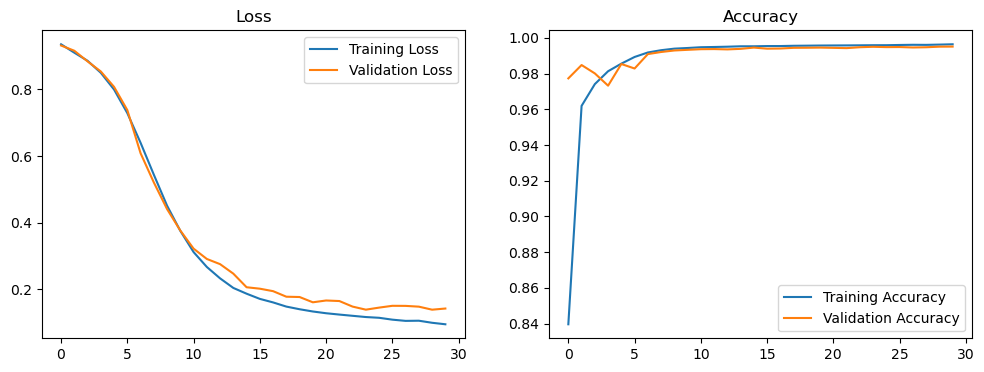

In [22]:
# Visualize training results
def plot_results(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

plot_results(history)


Processing image 1/5: 1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


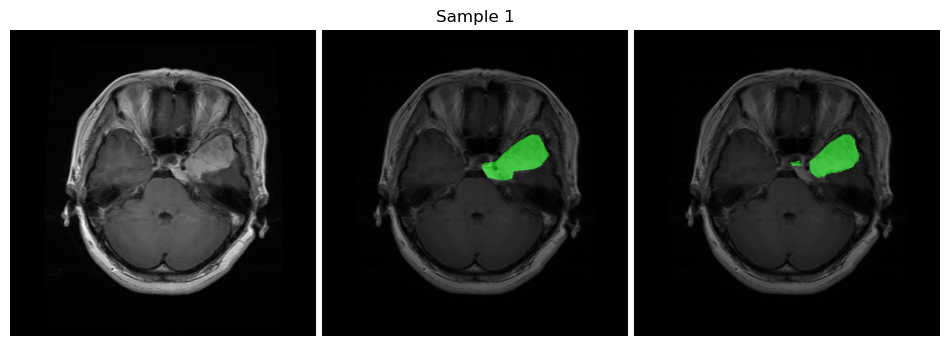

Processing image 2/5: 10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


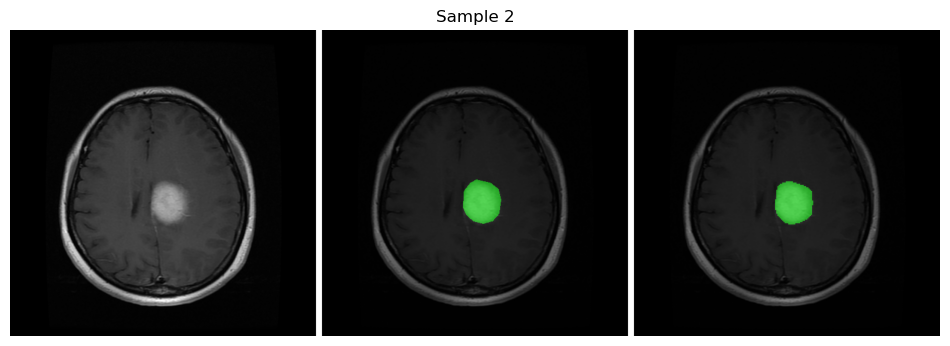

Processing image 3/5: 100.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


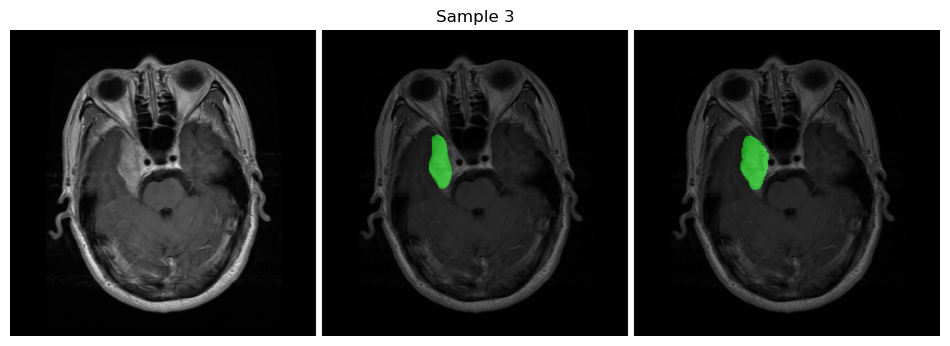

Processing image 4/5: 1000.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


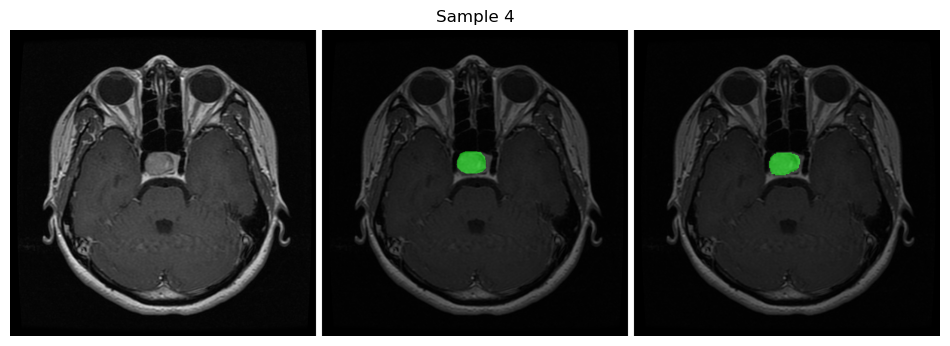

Processing image 5/5: 1001.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


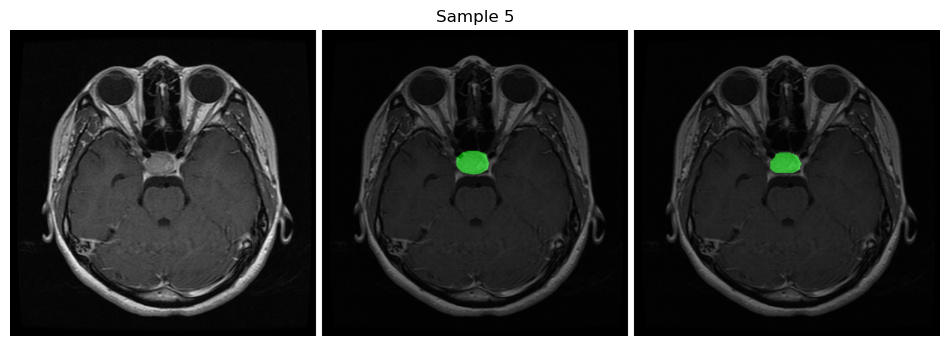

In [20]:
# Visualize predictions
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Function to overlay a mask onto an image
def overlay_mask(image_path, mask, mask_color=(0, 255, 0), alpha=0.5):
    
    # Load the original image
    image = Image.open(image_path).convert("RGB")
    image_array = np.array(image)

    # Ensure mask is a binary array (2D)
    if len(mask.shape) == 3:  # If mask is 3D, squeeze the last dimension
        mask = np.squeeze(mask, axis=-1)

    # Resize the mask to match the image resolution
    mask = cv2.resize(mask.astype(np.float32), (image_array.shape[1], image_array.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Convert mask to uint8
    mask = (mask * 255).astype(np.uint8)
    mask = Image.fromarray(mask).convert("L")  # Convert to grayscale PIL image

    # Create a colored mask
    colored_mask = np.zeros_like(image_array)
    colored_mask[:, :, :] = mask_color  # Set the mask color
    colored_mask = np.where(np.expand_dims(np.array(mask) > 0, axis=-1), colored_mask, 0)

    # Blend the original image with the colored mask
    blended_image = image_array * (1 - alpha) + colored_mask * alpha
    blended_image = blended_image.astype(np.uint8)

    # Convert back to PIL Image
    result_image = Image.fromarray(blended_image)
    return result_image

# Function to visualize predictions
def visualize_predictions(main_folder, num_samples=10, mask_color=(0, 255, 0), alpha=0.5):
    
    # Define paths for images, masks, and overlaid masks
    image_folder = os.path.join(main_folder, "images")
    overlaid_mask_folder = os.path.join(main_folder, "overlaid_masks")

    # Get all image filenames
    image_files = sorted(os.listdir(image_folder))[:num_samples]

    # Process each image
    for i, image_filename in enumerate(image_files):
        print(f"Processing image {i + 1}/{len(image_files)}: {image_filename}")

        # Construct paths
        image_path = os.path.join(image_folder, image_filename)
        overlaid_mask_path = os.path.join(overlaid_mask_folder, image_filename)

        # Load images
        original_image = Image.open(image_path).convert("RGB")
        overlaid_ground_truth_mask = Image.open(overlaid_mask_path).convert("RGB")

        # Generate predicted mask using the model
        x = read_image(image_path.encode())  # Read the original image for prediction
        y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5  # Predict mask

        # Ensure y_pred is a 2D array (squeeze the last dimension if necessary)
        y_pred = np.squeeze(y_pred, axis=-1)

        # Overlay the predicted mask on the original image
        overlaid_predicted_mask = overlay_mask(image_path, y_pred, mask_color, alpha)

        # Concatenate images side by side
        white_line = Image.new("RGB", (10, original_image.height), color="white")
        combined_image = np.concatenate(
            [
                np.array(original_image),
                np.array(white_line),
                np.array(overlaid_ground_truth_mask),
                np.array(white_line),
                np.array(overlaid_predicted_mask),
            ],
            axis=1,
        )

        # Display the combined image
        plt.figure(figsize=(12, 6))
        plt.imshow(combined_image)
        plt.title(f"Sample {i + 1}")
        plt.axis("off")
        plt.show()

# Example usage
main_folder = "C:\\Users\\saika\\OneDrive\\Desktop\\brats"
visualize_predictions(main_folder, num_samples=5, mask_color=(0, 255, 0), alpha=0.5)